In [6]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

## Autoregressive forecaster

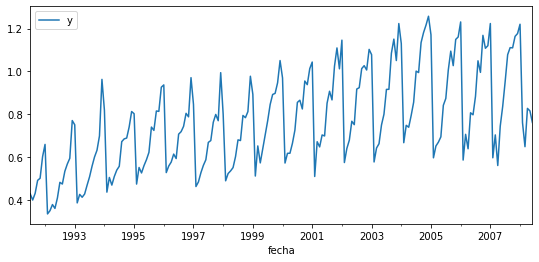

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
ax.legend();

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=Ridge(),
                    lags=15
                )
forecaster.fit(y=data_train)
forecaster

<class 'skforecast.ForecasterAutoreg.ForecasterAutoreg'> 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-10-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Test error (mse): 0.009918738501371824


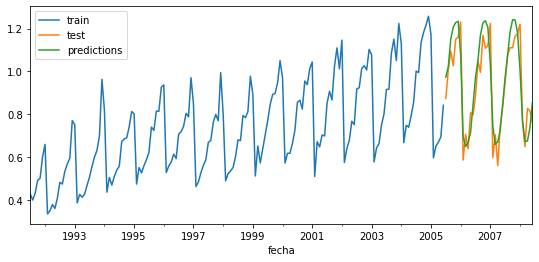

In [5]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=Ridge(),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.025318,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.025755,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.030505,1.00
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.043651,0.01
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.044092,0.10
8,"[1, 2, 3, 20]",{'alpha': 1},0.047499,1.00
0,"[1, 2, 3]",{'alpha': 0.01},0.058317,0.01
1,"[1, 2, 3]",{'alpha': 0.1},0.058340,0.10
2,"[1, 2, 3]",{'alpha': 1},0.059168,1.00


In [7]:
# Predictors importance
# ==============================================================================
print(forecaster.get_coef())

[ 0.64809274 -0.04771788  0.12042237 -0.10951344 -0.04541451  0.05163303
 -0.14294017  0.0682693   0.05806128  0.26129814]


Number of observations used for training or as initial window: 95
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.03468267]


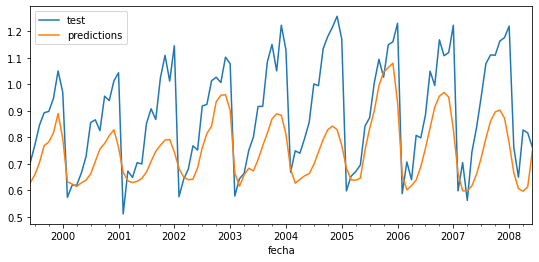

In [8]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]

steps = 36
regressor = Ridge()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
predicciones_backtest

1999-06-01    0.628054
1999-07-01    0.658490
1999-08-01    0.704903
1999-09-01    0.768430
1999-10-01    0.782291
                ...   
2008-02-01    0.666095
2008-03-01    0.606199
2008-04-01    0.596363
2008-05-01    0.613200
2008-06-01    0.749471
Freq: MS, Name: pred, Length: 109, dtype: float64

In [10]:
forecaster.fit(y=data_train)
predictions_1 = forecaster.predict(steps=steps)
print(len(predictions_1), predictions_1)
print("")
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps])
print(len(predictions_2), predictions_2)
print("")
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2])
print(len(predictions_3), predictions_3)
print("")
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3])
print(len(predictions_4), predictions_4)
print("")

36 1999-06-01    0.628054
1999-07-01    0.658490
1999-08-01    0.704903
1999-09-01    0.768430
1999-10-01    0.782291
1999-11-01    0.816752
1999-12-01    0.889629
2000-01-01    0.795110
2000-02-01    0.631964
2000-03-01    0.623642
2000-04-01    0.614602
2000-05-01    0.628016
2000-06-01    0.637877
2000-07-01    0.661432
2000-08-01    0.708668
2000-09-01    0.755855
2000-10-01    0.776660
2000-11-01    0.806120
2000-12-01    0.828475
2001-01-01    0.761619
2001-02-01    0.668007
2001-03-01    0.635597
2001-04-01    0.628964
2001-05-01    0.633647
2001-06-01    0.644625
2001-07-01    0.668621
2001-08-01    0.709280
2001-09-01    0.747269
2001-10-01    0.769671
2001-11-01    0.789822
2001-12-01    0.791660
2002-01-01    0.744339
2002-02-01    0.682452
2002-03-01    0.649604
2002-04-01    0.639892
2002-05-01    0.641724
Freq: MS, Name: pred, dtype: float64

36 2002-06-01    0.685014
2002-07-01    0.760285
2002-08-01    0.814806
2002-09-01    0.841847
2002-10-01    0.934201
2002-11-01   

In [11]:
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

### Autoreg + 1 exogenous predictor
<br>

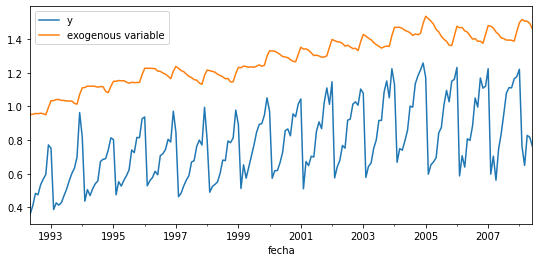

In [12]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Exogenous variable
# ==============================================================================
data_exog = data.rolling(window=10, closed='right').mean() + 0.5
data_exog = data_exog[10:]
data = data[10:]

fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax, label='y')
data_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

data_exog_train = data_exog[:-steps]
data_exog_test  = data_exog[-steps:]

Test error (mse): 0.020306077140235624


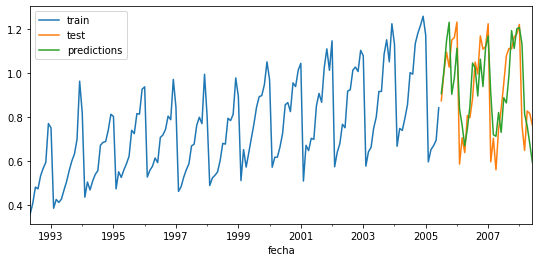

In [13]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=data_train, exog=data_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_exog_test)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [14]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train,
                        exog        = data_exog_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:05<00:00,  1.76s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3 20] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.054245,10,50
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.059871,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.062230,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.062298,10,100
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.062390,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.065474,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.065545,5,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.066951,5,100
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.071877,5,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.073482,5,100


In [15]:
# Backtesting
# ==============================================================================
n_test = 36*3 + 1
data_train = data[:-n_test]
data_test  = data[-n_test:]
data_exog_train = data_exog[:-n_test]
data_exog_test  = data_exog[-n_test:]

steps = 36
lags  = 15
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data,
    exog       = data_exog,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

# Verificar predicciones de backtesting
forecaster.fit(y=data_train, exog=data_exog_train)
predictions_1 = forecaster.predict(steps=steps, exog=data_exog_test[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test[:steps], exog=data_exog_test[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test[steps:steps*2], exog=data_exog_test[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test[steps*2:steps*3], exog=data_exog_test[steps*3:steps*4])
(predicciones_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

Number of observations used for training or as initial window: 85
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[2.1032823e-29]


True

### Autoregressive + n exogenous predictors
<br>

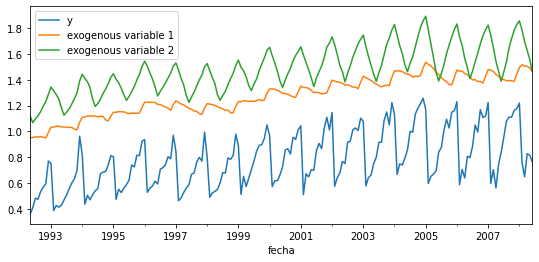

In [16]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_1.name = 'exogenous variable 1'
datos_exog_2 = datos.rolling(window=5, closed='right').mean() + 0.7
datos_exog_2.name = 'exogenous variable 2'
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos.iloc[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax)
datos_exog_2.plot(ax=ax)
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos.iloc[:-steps]
datos_test  = datos.iloc[-steps:]

datos_exog = pd.concat((datos_exog_1, datos_exog_2), axis=1)
datos_exog_train = datos_exog.iloc[:-steps,]
datos_exog_test  = datos_exog.iloc[-steps:,]

Test error (mse): 0.03028522529411062


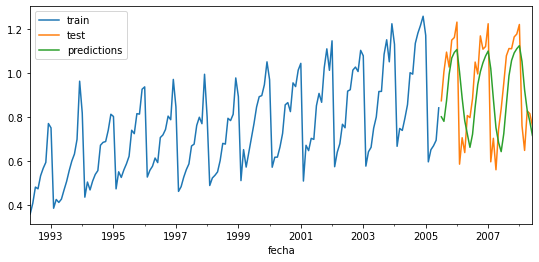

In [17]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=datos_exog_test)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

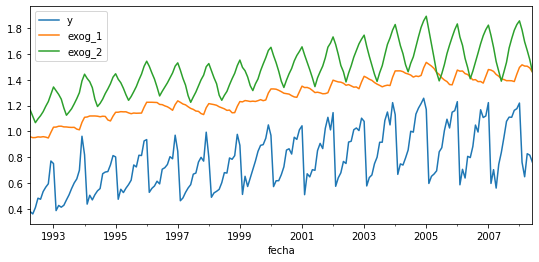

In [18]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [19]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 2
             )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])
# Add datetime index
predictions = pd.Series(data=predictions, index=data_test.index)

# Error
# ==============================================================================
error_mse = mean_squared_error(
            y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.030285034610348982


In [20]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
             )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 12
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:11<00:00,  3.77s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.017946,10,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.020676,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.020877,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.021233,5,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.025297,5,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.027193,10,100
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.027272,5,100
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.027490,5,50
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.027967,10,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.028001,5,50


## Información de sesión

In [ ]:
from sinfo import sinfo
sinfo()